<a href="https://colab.research.google.com/github/ducshaf/gan_uet/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pytorch-lightning
!pip install torchtext

In [5]:
%matplotlib inline
import os
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F;
import torch.utils.data as data

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import pytorch_lightning as pl


In [6]:
def visualize_data(data_loader):
  images, labels = next(iter(data_loader))
  images = images.numpy()

  fig, axes = plt.subplots(figsize=(5,3), nrows=3, ncols=5, sharex=True, sharey=True)
  i = 0
  for ax_row in axes:
    for ax in ax_row:
      img = np.squeeze(images[i])
      ax.imshow(img.reshape((28,28)), cmap='Greys_r')
      ax.xaxis.set_visible(False)
      ax.yaxis.set_visible(False)
      i += 1

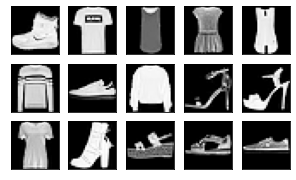

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
data_loader = data.DataLoader(train_data, batch_size=batch_size)

visualize_data(data_loader=data_loader)

# **DISCRIMINATOR**

In [8]:
class Discriminator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size, n_class=10):
    super(Discriminator, self).__init__()

    self.label_embed = nn.Embedding(n_class, n_class)
    self.model = nn.Sequential(
        nn.Linear(input_size + n_class, hidden_dim*4),    # layer 1
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(hidden_dim*4, hidden_dim*2),            # layer 2
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(hidden_dim*2, hidden_dim),              # layer 3
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(hidden_dim, output_size),               # classification layer
      )

  def forward(self, x, y):
    x = x.view(-1, 28*28) # flatten to n tensor size 784
    label = self.label_embed(y)
    x = torch.cat([x, label], dim=-1)
    out = self.model(x)   # output should be {0,1}

    return out

# **GENERATOR**





In [9]:
class Generator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size, n_class=10):
    super(Generator, self).__init__()

    self.label_embed = nn.Embedding(n_class, n_class)
    self.model = nn.Sequential(
        nn.Linear(input_size + n_class, hidden_dim),      # layer 1
        nn.BatchNorm1d(hidden_dim),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(hidden_dim, hidden_dim*2),    # layer 2
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(hidden_dim*2, hidden_dim*4),  # layer 3
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(hidden_dim*4, output_size),   # layer 4
        nn.Tanh()
      )

  def forward(self, x, y):
    label = self.label_embed(y)
    x = torch.cat([x, label], dim=-1) 
    out = self.model(x)   # output should be m tensor size 784
    return out

In [10]:
def cal_real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
      labels = torch.ones(batch_size)*0.9 
    else: 
      labels = torch.ones(batch_size)

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def cal_fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss 

g_losses = []
d_losses = []
samples = []

class GAN(pl.LightningModule):
  def __init__(self, g_input_size=100, g_hidden_size=32, g_output_size=784,
                     d_input_size=784, d_hidden_size=32, d_output_size=1):
    super().__init__()
    self.save_hyperparameters()

    self.generator = Generator(g_input_size, g_hidden_size, g_output_size).to(device)
    self.discriminator = Discriminator(d_input_size, d_hidden_size, d_output_size).to(device)
  
  def forward(self, z, y):
    return self.generator(z, y)

  
  def training_step(self, batch, batch_idx, optimizer_idx):
    real_imgs, real_y = batch
    real_imgs = real_imgs*2 - 1   # from {0,1} to {-1, 1}

    # train generator
    if optimizer_idx == 0:
      # generator input noises and labels
      z = np.random.uniform(-1, 1, size=(real_imgs.size(0), self.hparams.g_input_size))
      z = torch.from_numpy(z).float()
      y = np.random.random_integers(0, 9, size=(real_imgs.size(0),))
      y = torch.from_numpy(y).int()
      
      # calculate loss
      g_loss = cal_real_loss(self.discriminator(self(z, y), y)) # flip labels

      # logging
      self.g_losses = g_loss.item()
      self.log('g_loss', g_loss)
      tqdm_dict = {"g_loss": g_loss}
      output = OrderedDict({"loss": g_loss, "progress_bar": tqdm_dict, "log": tqdm_dict})
      return output

    # train discriminator
    if optimizer_idx == 1:
      # generator input noise
      z = np.random.uniform(-1, 1, size=(real_imgs.size(0), self.hparams.g_input_size))
      z = torch.from_numpy(z).float()
      y = np.random.random_integers(0, 9, size=(real_imgs.size(0),))
      y = torch.from_numpy(y).int()

      # calculate loss
      real_loss = cal_real_loss(self.discriminator(real_imgs, real_y), smooth=True)
      fake_loss = cal_fake_loss(self.discriminator(self(z, y).detach(), y))
      d_loss = real_loss + fake_loss

      #logging
      self.d_losses = d_loss.item()
      self.log('d_loss', d_loss)
      tqdm_dict = {"d_loss": d_loss}
      output = OrderedDict({"loss": d_loss, "progress_bar": tqdm_dict, "log": tqdm_dict})
      return output


  def configure_optimizers(self):
    # Use Adam algorithm
    d_optimizer = torch.optim.Adam(self.discriminator.parameters(), 0.002)
    g_optimizer = torch.optim.Adam(self.generator.parameters(), 0.002)
    return [g_optimizer, d_optimizer], []


  def on_epoch_end(self):
    d_losses.append(self.d_losses)
    g_losses.append(self.g_losses)

    # generator input noise
    z = np.random.uniform(-1, 1, size=(16, self.hparams.g_input_size))
    z = torch.from_numpy(z).float()
    y = np.random.random_integers(0, 9, size=(16,))
    y = torch.from_numpy(y).int()

    # logging
    sample_imgs = self(z, y)
    samples.append(sample_imgs)
    sample_imgs = torch.reshape(sample_imgs, (-1, 1, 28, 28))
    grid = torchvision.utils.make_grid(sample_imgs, 8)
    self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

In [22]:
model = GAN()
trainer = pl.Trainer(max_epochs=100, progress_bar_refresh_rate=20)
trainer.fit(model, data_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 115 K 
1 | discriminator | Discriminator | 112 K 
------------------------------------------------
227 K     Trainable params
0         Non-trainable params
227 K     Total params
0.910     Total esti

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'log', 'progress_bar'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead


# **View generated images, losses**

Compare losses

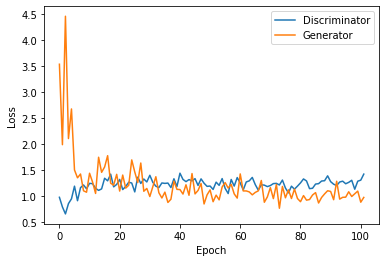

In [23]:
plt.figure()
plt.plot(d_losses)
plt.plot(g_losses)
plt.legend(['Discriminator', 'Generator'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

View sample

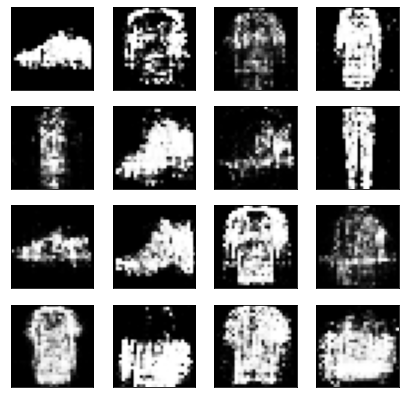

In [24]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

view_samples(-1, samples)

Samples throughout the training

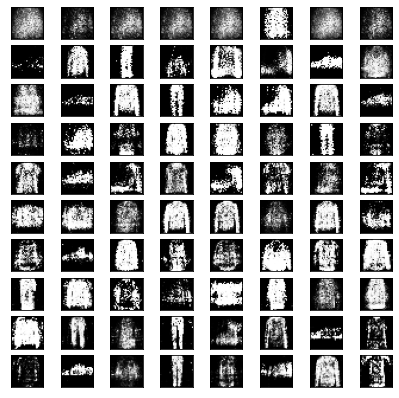

In [25]:
fig, axes = plt.subplots(figsize=(7,7), nrows=10, ncols=8, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/10)], axes):
    for img, ax in zip(sample[::int(len(sample)/8)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)